# Weekly Revenue Forecasting: LightGBM vs Lasso

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('feature_data/weekly_features.csv')
df.dtypes

week_start_date                    object
coffee_name                        object
weekly_revenue                    float64
weekly_transactions                 int64
avg_transaction_value             float64
transaction_value_volatility      float64
month_first                         int64
week_of_year_first                  int64
hour_of_day_mean                  float64
hour_of_day_std                   float64
hour_of_day_min                     int64
hour_of_day_max                     int64
dominant_day_of_week                int64
weekend_sales_proportion          float64
dominant_time_of_day               object
dominant_weekday                   object
year_week                          object
coffee_encoded                      int64
prev_week_revenue                 float64
prev_week_transactions            float64
prev_2week_revenue                float64
prev_3week_revenue                float64
prev_2week_transactions           float64
prev_3week_transactions           

### Data Prep for LightGBM training for Weekly Revenue prediction by Coffee Name

In [3]:
weekly_features = df.copy()

training_features = [
    # Coffee identifier
    'coffee_encoded',
    
    # lag features
    'prev_week_revenue', 'prev_week_transactions',
    'prev_2week_revenue', 'prev_3week_revenue', 
    'prev_2week_transactions', 'prev_3week_transactions',
    
    # Temporal features
    'month_first', 'week_of_year_first', 'dominant_day_of_week',
    'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
    
    # Sales pattern features
    'weekend_sales_proportion', 'hour_of_day_mean', 'hour_of_day_std',
    'hour_of_day_min', 'hour_of_day_max',
    
    # rolling features
    'revenue_4w_mean', 'revenue_4w_std', 'transactions_4w_mean',
    'revenue_8w_mean', 'revenue_12w_mean',
    'transactions_8w_mean', 'transactions_12w_mean',
    
    # Historical seasonal comparisons
    'revenue_same_week_4w_ago', 'revenue_same_week_8w_ago',
    
    # interaction features
    'prev_revenue_x_month', 'prev_revenue_x_week_of_year',
    'transactions_x_weekend_prop', 'coffee_month_interaction',
    'weekend_proportion_interaction'
]

In [4]:
X_weekly = weekly_features[training_features]
y_weekly = weekly_features['weekly_revenue']  # Target: weekly revenue
coffee_names_weekly = weekly_features['coffee_name']
dates_weekly = pd.to_datetime(weekly_features['week_start_date'])

# Remove rows with missing target values (first few weeks due to lag features)
valid_mask = (weekly_features['prev_week_revenue'] != 0) | (weekly_features['weekly_revenue'] > 0)
X_clean = X_weekly[valid_mask].copy()
y_clean = y_weekly[valid_mask].copy()

### Univariate Feature Selection

In [5]:
# Select best features using recursive feature elimination
# Tests each feature individually against the target and calculated F-stat (linear relationship)
print(f"Prior to univariate feature selection, there are {len(training_features)} features")
selector = SelectKBest(score_func=f_regression, k=25)
X_selected = selector.fit_transform(X_clean, y_clean)
selected_features = [training_features[i] for i in selector.get_support(indices=True)]

print(f"Top {len(selected_features)} features selected:")
for feature in selected_features:
    print(f"  • {feature}")

Prior to univariate feature selection, there are 33 features
Top 25 features selected:
  • coffee_encoded
  • prev_week_revenue
  • prev_week_transactions
  • prev_2week_revenue
  • prev_3week_revenue
  • prev_2week_transactions
  • prev_3week_transactions
  • week_of_year_cos
  • month_cos
  • hour_of_day_std
  • hour_of_day_min
  • hour_of_day_max
  • revenue_4w_mean
  • revenue_4w_std
  • transactions_4w_mean
  • revenue_8w_mean
  • revenue_12w_mean
  • transactions_8w_mean
  • transactions_12w_mean
  • revenue_same_week_4w_ago
  • revenue_same_week_8w_ago
  • prev_revenue_x_month
  • prev_revenue_x_week_of_year
  • transactions_x_weekend_prop
  • coffee_month_interaction


In [6]:
# reset X_weekly and X_clean based on selected features
X_weekly =  weekly_features[selected_features]
X_clean = X_weekly[valid_mask].copy()

In [7]:
coffee_clean = coffee_names_weekly[valid_mask].copy()
dates_clean = dates_weekly[valid_mask].copy()

print(f"Weekly dataset shape: {X_clean.shape}")
print(f"Date range: {dates_clean.min()} to {dates_clean.max()}")
print(f"Coffee types: {coffee_clean.nunique()}")
print(f"Target variable (weekly revenue) statistics:")
print(y_clean.describe())

print(f"\nWeekly features prepared for LightGBM training:")
print(f"Features: {len(X_weekly.columns)}")
print(f"Samples: {len(X_clean)}")

Weekly dataset shape: (421, 25)
Date range: 2024-02-26 00:00:00 to 2025-03-17 00:00:00
Coffee types: 8
Target variable (weekly revenue) statistics:
count     421.000000
mean      266.616580
std       219.737198
min        18.120000
25%        98.460000
50%       207.680000
75%       393.360000
max      1358.880000
Name: weekly_revenue, dtype: float64

Weekly features prepared for LightGBM training:
Features: 25
Samples: 421


The model **correctly** handles multiple coffee types with the same dates because:
- **`coffee_encoded` (0-7) identifies each coffee type**
- **Lag features are coffee-specific** (calculated within each coffee group)
- LightGBM splits on `coffee_encoded` to learn separate patterns per coffee
- Example: "If coffee=0 (Americano) AND prev_week_revenue=200 AND week=10 → predict X"

In [8]:
# Final check for correlations with target to ensure no target leakage
numeric_X_clean = X_clean.select_dtypes(include=[np.number])
feature_correlations = numeric_X_clean.corrwith(y_clean).abs().sort_values(ascending=False)
print(" Feature correlations w/ target")
print(feature_correlations)

 Feature correlations w/ target
revenue_4w_mean                0.724365
transactions_4w_mean           0.709770
prev_week_revenue              0.705394
prev_week_transactions         0.687293
revenue_8w_mean                0.682877
transactions_8w_mean           0.676851
prev_2week_revenue             0.666045
prev_2week_transactions        0.650487
revenue_12w_mean               0.646072
transactions_12w_mean          0.637415
prev_3week_revenue             0.593458
prev_3week_transactions        0.577875
revenue_4w_std                 0.570229
revenue_same_week_4w_ago       0.549188
prev_revenue_x_month           0.517701
prev_revenue_x_week_of_year    0.508765
hour_of_day_max                0.482724
hour_of_day_min                0.479237
transactions_x_weekend_prop    0.443400
revenue_same_week_8w_ago       0.438130
hour_of_day_std                0.379708
coffee_encoded                 0.130222
month_cos                      0.062748
week_of_year_cos               0.060098
coffee_m

In [ ]:
lgb_params = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'],
    'boosting_type': 'gbdt',
    'num_leaves': 100,          # Increased complexity
    'learning_rate': 0.02,      # Lower for better convergence
    'feature_fraction': 0.9,    # Use more features
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'min_child_samples': 5,     # Allow smaller splits
    'min_child_weight': 1e-4,
    'reg_alpha': 0.01,         # Less regularization
    'reg_lambda': 0.01,
    'max_depth': 12,           # Deeper trees
    'min_split_gain': 0.01,
    'random_state': 42,
    'verbose': -1,
    'force_col_wise': True
}

In [10]:
"""
Fold 1: Train on first 40% → Validate on next 15% (samples 40-55%)
Fold 2: Train on first 55% → Validate on next 15% (samples 55-70%)
Fold 3: Train on first 70% → Validate on next 15% (samples 70-85%)
Fold 4: Train on first 85% → Validate on next 15% (samples 85-100%)
"""

def chronological_time_series_split(X, y, dates, n_splits=4):
    """Create chronological time series splits with expanding training windows."""
    # Sort by date
    date_order = dates.argsort()
    sorted_indices = X.index[date_order]
    
    n_samples = len(sorted_indices)
    initial_train_size = int(n_samples * 0.4)  # Start with 40% for training
    val_window_size = int(n_samples * 0.15)    # 15% for each validation window
    
    splits = []
    for fold in range(n_splits):
        # Expanding training window
        train_end = initial_train_size + (fold * val_window_size)
        val_start = train_end
        val_end = val_start + val_window_size
        
        if val_end > n_samples:
            break
            
        # Get indices
        train_indices = sorted_indices[:train_end]
        val_indices = sorted_indices[val_start:val_end]
        
        # Convert to positions in original dataframe
        train_positions = np.where(X.index.isin(train_indices))[0]
        val_positions = np.where(X.index.isin(val_indices))[0]
        
        splits.append((train_positions, val_positions))
    
    return splits

# Get chronological splits
splits = chronological_time_series_split(numeric_X_clean, y_clean, dates_clean, n_splits=4)

In [11]:
# Store results
fold_scores = []
fold_predictions = []
fold_models = []
fold_feature_importance = []

print(f"Performing chronological time series cross validation...")
print(f"Total folds: {len(splits)}")
print()

# Only use numeric columns
X_clean_numeric = X_clean.select_dtypes(include=[np.number])

for fold_idx, (train_idx, val_idx) in enumerate(splits):
    fold_num = fold_idx + 1
    print(f"Training Fold {fold_num}/{len(splits)}...")
    
    # Split data
    X_train, X_val = X_clean_numeric.iloc[train_idx], X_clean_numeric.iloc[val_idx]
    y_train, y_val = y_clean.iloc[train_idx], y_clean.iloc[val_idx]
    
    # Show date ranges for this fold
    train_dates_fold = dates_clean.iloc[train_idx]
    val_dates_fold = dates_clean.iloc[val_idx]
    train_coffees_fold = coffee_clean.iloc[train_idx].unique()
    val_coffees_fold = coffee_clean.iloc[val_idx].unique()
    
    print(f"  Training: {train_dates_fold.min().strftime('%Y-%m-%d')} to {train_dates_fold.max().strftime('%Y-%m-%d')} ({len(X_train)} samples)")
    print(f"  Validation: {val_dates_fold.min().strftime('%Y-%m-%d')} to {val_dates_fold.max().strftime('%Y-%m-%d')} ({len(X_val)} samples)")
    print(f"  Coffee types: {len(train_coffees_fold)} in training, {len(val_coffees_fold)} in validation")
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train model
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    # Make predictions
    val_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    r2 = r2_score(y_val, val_pred)
    
    # Store results
    fold_scores.append({
        'fold': fold_num,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'train_date_range': f"{train_dates_fold.min().strftime('%Y-%m-%d')} to {train_dates_fold.max().strftime('%Y-%m-%d')}",
        'val_date_range': f"{val_dates_fold.min().strftime('%Y-%m-%d')} to {val_dates_fold.max().strftime('%Y-%m-%d')}"
    })
    
    fold_predictions.append({
        'fold': fold_num,
        'val_idx': val_idx,
        'y_true': y_val,
        'y_pred': val_pred,
        'coffee_names': coffee_clean.iloc[val_idx]
    })
    
    fold_models.append(model)
    fold_feature_importance.append(model.feature_importance(importance_type='gain'))
    
    print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    print()

# Results summary
scores_df = pd.DataFrame(fold_scores)
print(f"Chronological Time Series Cross-Validation Results")
print(f"Average MAE: {scores_df['mae'].mean():.2f} ± {scores_df['mae'].std():.2f}")
print(f"Average RMSE: {scores_df['rmse'].mean():.2f} ± {scores_df['rmse'].std():.2f}")
print(f"Average R²: {scores_df['r2'].mean():.3f} ± {scores_df['r2'].std():.3f}")

print(f"\n Detailed fold results:")
display_cols = ['fold', 'mae', 'rmse', 'r2', 'train_samples', 'val_samples']
print(scores_df[display_cols].round(3))

Performing chronological time series cross validation...
Total folds: 4

Training Fold 1/4...
  Training: 2024-02-26 to 2024-08-05 (168 samples)
  Validation: 2024-08-05 to 2024-09-30 (63 samples)
  Coffee types: 8 in training, 8 in validation
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[160]	train's rmse: 37.3693	train's l1: 20.7206	val's rmse: 143.109	val's l1: 97.7271
  MAE: 97.73, RMSE: 143.11, R²: 0.632

Training Fold 2/4...
  Training: 2024-02-26 to 2024-09-30 (231 samples)
  Validation: 2024-09-30 to 2024-11-25 (63 samples)
  Coffee types: 8 in training, 8 in validation
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's rmse: 72.654	train's l1: 49.2284	val's rmse: 170.045	val's l1: 110.674
  MAE: 110.67, RMSE: 170.04, R²: 0.597

Training Fold 3/4...
  Training: 2024-02-26 to 2024-11-25 (294 samples)
  Validation: 2024-11-25 to 2025-01-20 (63 samples)
  Coffee types: 8 in

In [12]:
# Performance by coffee type
all_predictions = []
for pred_data in fold_predictions:
    for i, idx in enumerate(pred_data['val_idx']):
        all_predictions.append({
            'fold': pred_data['fold'],
            'index': idx,
            'coffee_name': pred_data['coffee_names'].iloc[i],
            'y_true': pred_data['y_true'].iloc[i],
            'y_pred': pred_data['y_pred'][i]
        })

pred_df = pd.DataFrame(all_predictions)

# Calculate MAPE for business relevance
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Performance by coffee type
coffee_performance = pred_df.groupby('coffee_name').apply(
    lambda x: pd.Series({
        'samples': len(x),
        'avg_actual_revenue': x['y_true'].mean(),
        'avg_predicted_revenue': x['y_pred'].mean(),
        'mae': mean_absolute_error(x['y_true'], x['y_pred']),
        'rmse': np.sqrt(mean_squared_error(x['y_true'], x['y_pred'])),
        'r2': r2_score(x['y_true'], x['y_pred']),
        'mape': calculate_mape(x['y_true'], x['y_pred']),
        'prediction_bias': (x['y_pred'].mean() - x['y_true'].mean()) / x['y_true'].mean() * 100
    })
).round(3)

# Sort by R² score (best performing first)
coffee_performance_sorted = coffee_performance.sort_values('r2', ascending=False)

print("Performance by Coffee Type (sorted by R²):")
print(coffee_performance_sorted)

print(f"Average R² across all coffee types: {coffee_performance['r2'].mean():.3f}")

Performance by Coffee Type (sorted by R²):
                     samples  avg_actual_revenue  avg_predicted_revenue  \
coffee_name                                                               
Americano               33.0             314.293                277.245   
Cocoa                   31.0             238.136                242.716   
Cortado                 28.0             158.731                194.974   
Hot Chocolate           31.0             236.398                240.602   
Latte                   32.0             563.859                467.813   
Cappuccino              33.0             316.316                322.436   
Americano with Milk     33.0             489.837                472.858   
Espresso                31.0              52.941                103.171   

                         mae     rmse     r2     mape  prediction_bias  
coffee_name                                                             
Americano            128.623  184.974  0.548   70.069       

In [13]:
# Espresso r2 low?
espresso_data = pred_df[pred_df['coffee_name'] == 'Espresso']
print(f"\nEspresso analysis:")
# print(f"Total samples: {len(espresso_data)}")
# print(f"Folds with Espresso: {espresso_data['fold'].nunique()}")
# print(f"Samples per fold: {espresso_data.groupby('fold').size()}")

variance_analysis = pred_df.groupby('coffee_name').agg({
    'y_true': ['mean', 'std', 'var', 'min', 'max', 'count'],
    'y_pred': ['mean', 'std']
}).round(2)

variance_analysis.columns = ['actual_mean', 'actual_std', 'actual_var', 'actual_min', 'actual_max', 'samples', 
                           'pred_mean', 'pred_std']

# Calculate coefficient of variation (CV) for better comparison
variance_analysis['cv_actual'] = (variance_analysis['actual_std'] / variance_analysis['actual_mean'] * 100).round(1)
variance_analysis['cv_predicted'] = (variance_analysis['pred_std'] / variance_analysis['pred_mean'] * 100).round(1)

# Sort by variance (descending)
variance_analysis_sorted = variance_analysis.sort_values('actual_var', ascending=False)

# print("Variance Statistics (sorted by actual variance):")
# print(variance_analysis_sorted[['actual_mean', 'actual_std', 'actual_var', 'cv_actual', 'actual_min', 'actual_max']])

print(f"\n Coefficient of Variation (CV) Comparison:")
cv_comparison = variance_analysis_sorted[['samples','actual_mean', 'cv_actual', 'cv_predicted']].copy()
print(cv_comparison)

print(f"\n Insights:")
highest_variance_coffee = variance_analysis_sorted.index[0]
lowest_variance_coffee = variance_analysis_sorted.index[-1]
print("1. SAMPLE SIZE EFFECT:\n \
   • Americano: 54 samples (more data → better learning)\n \
   • Espresso: 37 samples (limited data → poor generalization")
print('=> Observe results after final time-series train/test predictions.')


Espresso analysis:

 Coefficient of Variation (CV) Comparison:
                     samples  actual_mean  cv_actual  cv_predicted
coffee_name                                                       
Americano                 33       314.29       88.9          50.2
Latte                     32       563.86       44.7          20.3
Americano with Milk       33       489.84       39.5          18.7
Cocoa                     31       238.14       70.0          43.0
Hot Chocolate             31       236.40       69.1          50.9
Cappuccino                33       316.32       41.2          26.7
Cortado                   28       158.73       52.2          29.5
Espresso                  31        52.94       65.6          44.0

 Insights:
1. SAMPLE SIZE EFFECT:
    • Americano: 54 samples (more data → better learning)
    • Espresso: 37 samples (limited data → poor generalization
=> Observe results after final time-series train/test predictions.


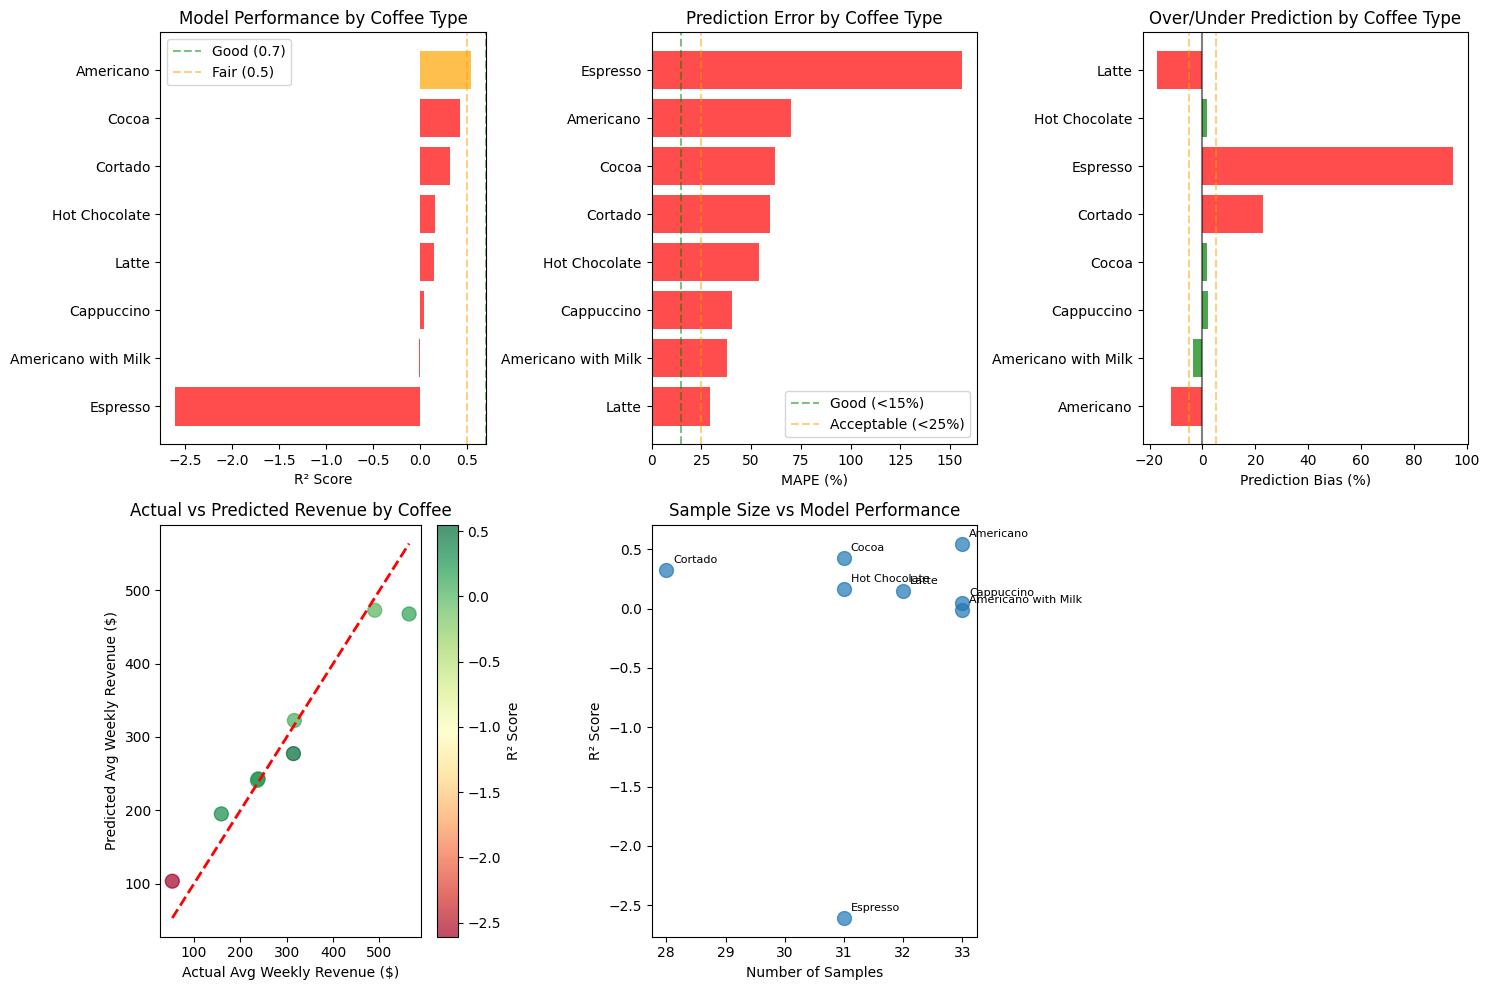

In [14]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
coffee_r2_sorted = coffee_performance.sort_values('r2')
colors = ['red' if x < 0.5 else 'orange' if x < 0.7 else 'green' for x in coffee_r2_sorted['r2']]
plt.barh(range(len(coffee_r2_sorted)), coffee_r2_sorted['r2'], color=colors, alpha=0.7)
plt.yticks(range(len(coffee_r2_sorted)), coffee_r2_sorted.index)
plt.xlabel('R² Score')
plt.title('Model Performance by Coffee Type')
plt.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Good (0.7)')
plt.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Fair (0.5)')
plt.legend()

plt.subplot(2, 3, 2)
coffee_mape_sorted = coffee_performance.sort_values('mape')
colors = ['green' if x < 15 else 'orange' if x < 25 else 'red' for x in coffee_mape_sorted['mape']]
plt.barh(range(len(coffee_mape_sorted)), coffee_mape_sorted['mape'], color=colors, alpha=0.7)
plt.yticks(range(len(coffee_mape_sorted)), coffee_mape_sorted.index)
plt.xlabel('MAPE (%)')
plt.title('Prediction Error by Coffee Type')
plt.axvline(x=15, color='green', linestyle='--', alpha=0.5, label='Good (<15%)')
plt.axvline(x=25, color='orange', linestyle='--', alpha=0.5, label='Acceptable (<25%)')
plt.legend()

plt.subplot(2, 3, 3)
colors = ['red' if abs(x) > 10 else 'orange' if abs(x) > 5 else 'green' for x in coffee_performance['prediction_bias']]
plt.barh(range(len(coffee_performance)), coffee_performance['prediction_bias'], color=colors, alpha=0.7)
plt.yticks(range(len(coffee_performance)), coffee_performance.index)
plt.xlabel('Prediction Bias (%)')
plt.title('Over/Under Prediction by Coffee Type')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.axvline(x=5, color='orange', linestyle='--', alpha=0.5)
plt.axvline(x=-5, color='orange', linestyle='--', alpha=0.5)

plt.subplot(2, 3, 4)
plt.scatter(coffee_performance['avg_actual_revenue'], coffee_performance['avg_predicted_revenue'], 
           s=100, alpha=0.7, c=coffee_performance['r2'], cmap='RdYlGn')
plt.plot([coffee_performance['avg_actual_revenue'].min(), coffee_performance['avg_actual_revenue'].max()], 
         [coffee_performance['avg_actual_revenue'].min(), coffee_performance['avg_actual_revenue'].max()], 
         'r--', lw=2)
plt.xlabel('Actual Avg Weekly Revenue ($)')
plt.ylabel('Predicted Avg Weekly Revenue ($)')
plt.title('Actual vs Predicted Revenue by Coffee')
plt.colorbar(label='R² Score')

plt.subplot(2, 3, 5)
plt.scatter(coffee_performance['samples'], coffee_performance['r2'], s=100, alpha=0.7)
for i, coffee in enumerate(coffee_performance.index):
    plt.annotate(coffee, (coffee_performance.loc[coffee, 'samples'], 
                         coffee_performance.loc[coffee, 'r2']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Number of Samples')
plt.ylabel('R² Score')
plt.title('Sample Size vs Model Performance')


plt.tight_layout()
plt.show()

### Training: 2024 → predict 2025 weekly revenue

In [15]:
# Load and prepare data
weekly_features = df.copy()
weekly_features['week_start_date'] = pd.to_datetime(weekly_features['week_start_date'])

# Split data
train_end_date = pd.to_datetime('2024-12-31')
test_start_date = pd.to_datetime('2025-01-01')

# Create time-based train/test split
train_mask = weekly_features['week_start_date'] <= train_end_date
test_mask = weekly_features['week_start_date'] >= test_start_date

train_data = weekly_features[train_mask].copy()
test_data = weekly_features[test_mask].copy()

print(f"Training data: {len(train_data)} samples")
print(f"  Date range: {train_data['week_start_date'].min()} to {train_data['week_start_date'].max()}")
print(f"  Coffee types: {train_data['coffee_name'].nunique()}")

print(f"\nTest data: {len(test_data)} samples")
print(f"  Date range: {test_data['week_start_date'].min()} to {test_data['week_start_date'].max()}")
print(f"  Coffee types: {test_data['coffee_name'].nunique()}")

# Remove rows with missing lag features
train_valid_mask = (train_data['prev_week_revenue'] != 0) | (train_data['weekly_revenue'] > 0)
train_clean = train_data[train_valid_mask].copy()

test_valid_mask = (test_data['prev_week_revenue'] != 0) | (test_data['weekly_revenue'] > 0)
test_clean = test_data[test_valid_mask].copy()

# Prepare training data
X_train = train_clean[selected_features]
y_train = train_clean['weekly_revenue']
coffee_train = train_clean['coffee_name']
dates_train = train_clean['week_start_date']

# Prepare test data
X_test = test_clean[selected_features]
y_test = test_clean['weekly_revenue']
coffee_test = test_clean['coffee_name']
dates_test = test_clean['week_start_date']

print(f"\nCleaned training data: {len(X_train)} samples")
print(f"Cleaned test data: {len(X_test)} samples")

Training data: 337 samples
  Date range: 2024-02-26 00:00:00 to 2024-12-30 00:00:00
  Coffee types: 8

Test data: 84 samples
  Date range: 2025-01-06 00:00:00 to 2025-03-17 00:00:00
  Coffee types: 8

Cleaned training data: 337 samples
Cleaned test data: 84 samples


In [ ]:
print(f"\n Training model on 2024 data")
train_data_final = lgb.Dataset(X_train, label=y_train)

final_model = lgb.train(
    lgb_params,
    train_data_final,
    num_boost_round=1000,
    valid_sets=[train_data_final],
    valid_names=['train'],
    callbacks=[lgb.log_evaluation(0)]
)

print(f"\n Predicting 2025 weekly revenue overall...")
predictions_2025 = final_model.predict(X_test)

results_2025 = pd.DataFrame({
    'week_start_date': dates_test,
    'coffee_name': coffee_test,
    'actual_revenue': y_test,
    'predicted_revenue': predictions_2025,
    'prediction_error': predictions_2025 - y_test,
    'absolute_error': np.abs(predictions_2025 - y_test),
    'percentage_error': ((predictions_2025 - y_test) / y_test) * 100
})

# overall 2025 prediction metrics
mae_2025 = mean_absolute_error(y_test, predictions_2025)
rmse_2025 = np.sqrt(mean_squared_error(y_test, predictions_2025))
r2_2025 = r2_score(y_test, predictions_2025)
mape_2025 = np.mean(np.abs((y_test - predictions_2025) / y_test)) * 100

print(f"2025 Prediction Performance:")
print(f"  MAE: ${mae_2025:.2f}")
print(f"  RMSE: ${rmse_2025:.2f}")
print(f"  R²: {r2_2025:.3f}")
print(f"  MAPE: {mape_2025:.1f}%")

# Performance by coffee type for combined 2025 predictions
coffee_performance_2025 = results_2025.groupby('coffee_name').agg({
    'actual_revenue': ['count', 'mean'],
    'predicted_revenue': 'mean',
    'absolute_error': 'mean',
    'percentage_error': ['mean', 'std']
}).round(2)

coffee_performance_2025.columns = ['weeks_predicted', 'avg_actual', 'avg_predicted', 'mae', 'mape_mean', 'mape_std']

print(f"\n2025 performance by coffee type")
print(coffee_performance_2025.sort_values('mape_mean'))


 Training final model on 2024 data with validation split
  Training subset: 269 samples (2024-02-26 to 2024-11-04)
  Validation subset: 68 samples (2024-11-04 to 2024-12-30)
  Model stopped at iteration: 16
  Best validation RMSE: 117.97

 Predicting 2025 weekly revenue overall...
2025 Prediction Performance:
  MAE: $166.80
  RMSE: $226.60
  R²: 0.154
  MAPE: 92.5%

2025 performance by coffee type
                     weeks_predicted  avg_actual  avg_predicted     mae  \
coffee_name                                                               
Americano with Milk               11      510.59         333.88  208.96   
Latte                             11      484.39         355.98  176.18   
Cappuccino                        11      380.36         295.20  130.72   
Americano                         11      564.04         269.11  359.63   
Cocoa                             11      315.34         278.82  133.85   
Hot Chocolate                     11      224.31         232.65   91.78  

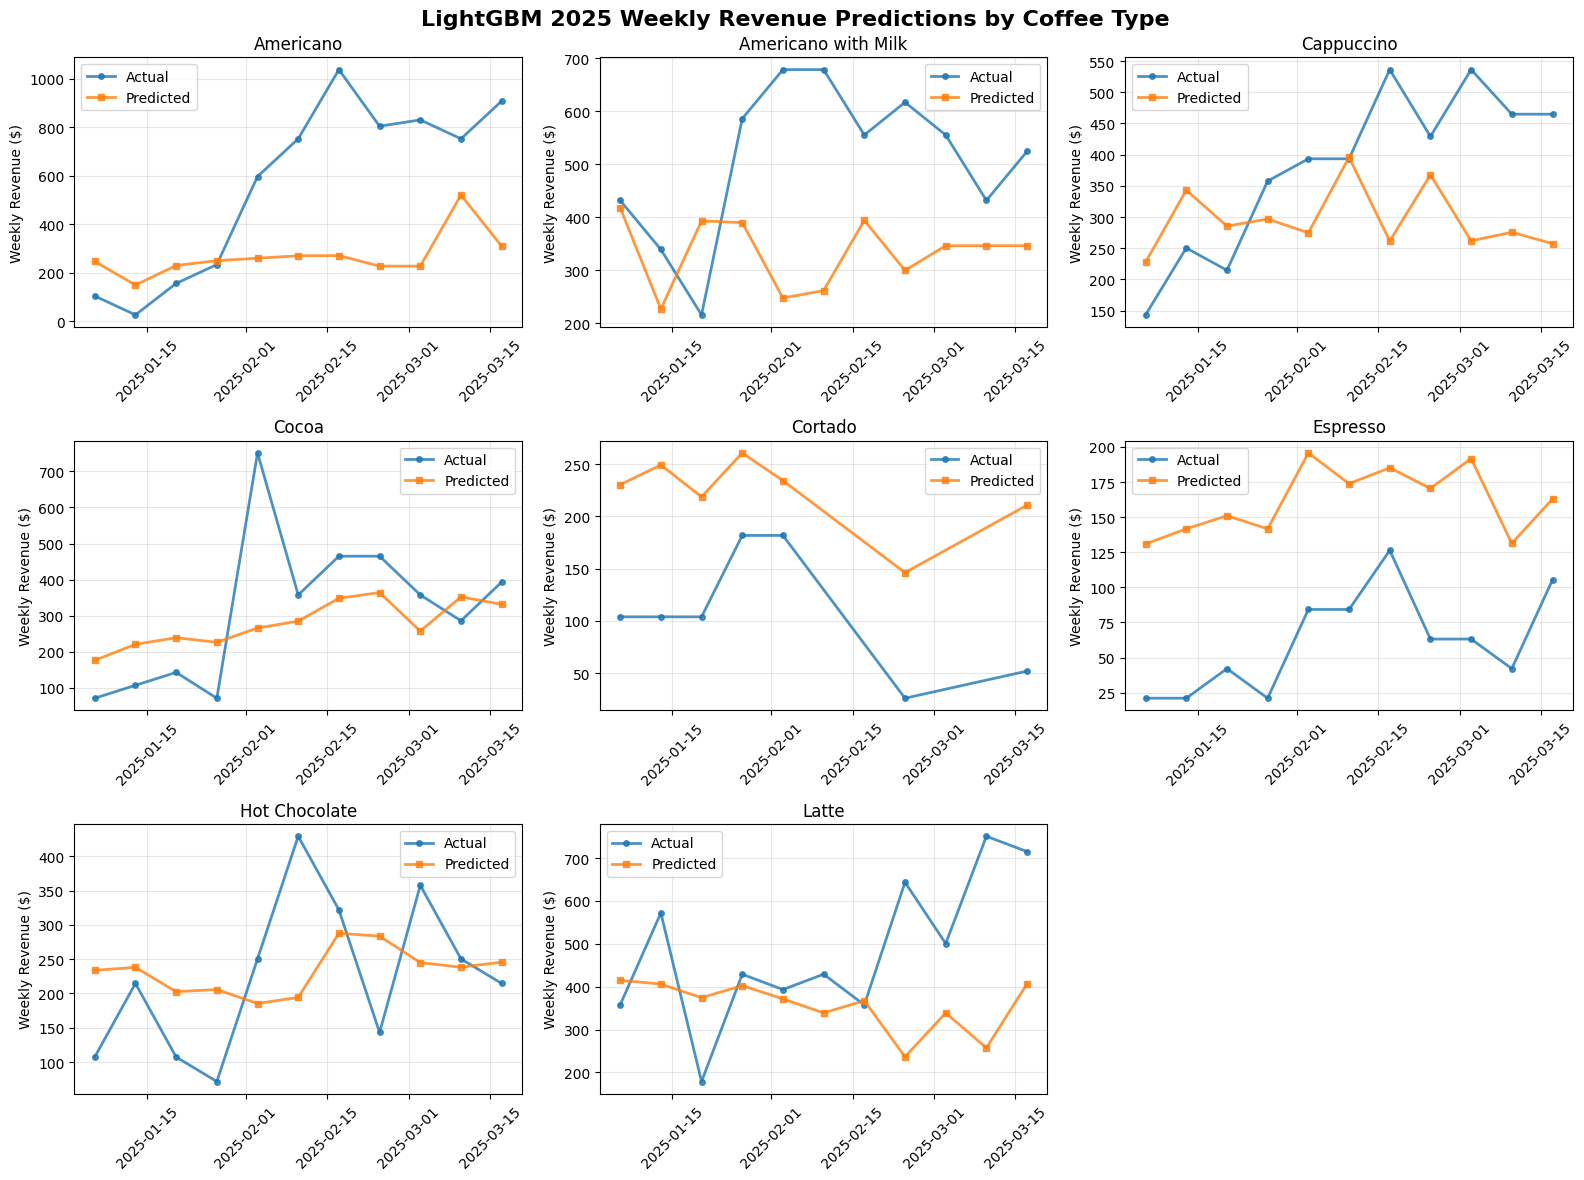

In [17]:
def plot_time_series_predictions(results_df, model_type="Model", figsize=(16, 12)):
    """
    Plot time series predictions for each coffee type.
    
    Parameters:
    results_df: DataFrame with columns ['week_start_date', 'coffee_name', 'actual_revenue', 'predicted_revenue']
    model_type: str, name of the model for the title
    figsize: tuple, figure size
    """
    plt.figure(figsize=figsize)
    
    unique_coffees = results_df['coffee_name'].unique()
    n_coffees = len(unique_coffees)
    cols = 3
    rows = (n_coffees + cols - 1) // cols

    for i, coffee in enumerate(unique_coffees):
        plt.subplot(rows, cols, i + 1)
        
        coffee_data = results_df[results_df['coffee_name'] == coffee].sort_values('week_start_date')
        
        plt.plot(coffee_data['week_start_date'], coffee_data['actual_revenue'], 
                 'o-', label='Actual', linewidth=2, markersize=4, alpha=0.8)
        plt.plot(coffee_data['week_start_date'], coffee_data['predicted_revenue'], 
                 's-', label='Predicted', linewidth=2, markersize=4, alpha=0.8)
        
        plt.title(f'{coffee}')
        plt.ylabel('Weekly Revenue ($)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.suptitle(f'{model_type} 2025 Weekly Revenue Predictions by Coffee Type', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot LightGBM results
plot_time_series_predictions(results_2025, "LightGBM")

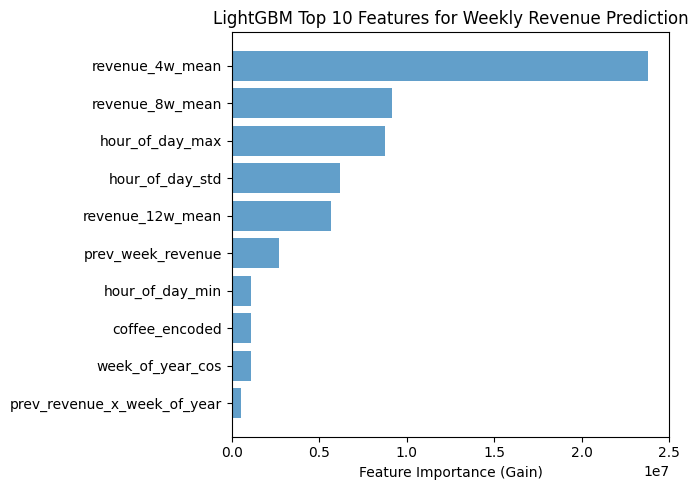

In [18]:
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importance(importance_type='gain')
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(7, 5))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('LightGBM Top 10 Features for Weekly Revenue Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Train & Predict Separate LightGBM Models per Coffee Type

In [ ]:
unique_coffees = coffee_train.unique()
coffee_models = {}
coffee_results_separate = []

# Simplified parameters for small sample sizes (separate models)
lgb_params_separate = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'],
    'boosting_type': 'gbdt',
    'num_leaves': 15,           # Much smaller - only ~40 samples per coffee
    'learning_rate': 0.05,      # Faster learning
    'feature_fraction': 0.7,    # Strong regularization
    'bagging_fraction': 0.7,    # Strong regularization
    'bagging_freq': 5,
    'min_child_samples': 3,     # Allow small samples but not too small
    'min_child_weight': 1e-3,
    'reg_alpha': 0.5,           # Very strong L1 regularization
    'reg_lambda': 0.5,          # Very strong L2 regularization
    'max_depth': 4,             # Very shallow trees
    'min_split_gain': 0.1,
    'random_state': 42,
    'verbose': -1,
    'force_col_wise': True
}

for coffee in unique_coffees:
    print(f"Training model for {coffee}...")
    
    # Filter training data for coffee
    coffee_mask_train = coffee_train == coffee
    X_train_coffee = X_train[coffee_mask_train]
    y_train_coffee = y_train[coffee_mask_train]
    
    # Filter test data for coffee
    coffee_mask_test = coffee_test == coffee
    X_test_coffee = X_test[coffee_mask_test]
    y_test_coffee = y_test[coffee_mask_test]
    
    # flag if less than 5 training weeks or less than 2 test weeks
    if len(X_train_coffee) < 5 or len(X_test_coffee) < 2:
        print(f"  Insufficient data for {coffee} (train: {len(X_train_coffee)}, test: {len(X_test_coffee)})")
        continue
    
    # Remove coffee_encoded feature since we are training per coffee
    features_no_coffee = [f for f in selected_features if f != 'coffee_encoded']
    X_train_coffee_clean = X_train_coffee[features_no_coffee]
    X_test_coffee_clean = X_test_coffee[features_no_coffee]
    
    # Create validation split (80/20) from training data for early stopping
    n_samples = len(X_train_coffee_clean)
    val_size = max(2, int(n_samples * 0.2))  # At least 2 samples for validation
    train_size = n_samples - val_size
    
    # Use last samples chronologically for validation
    X_train_split = X_train_coffee_clean.iloc[:train_size]
    y_train_split = y_train_coffee.iloc[:train_size]
    X_val_split = X_train_coffee_clean.iloc[train_size:]
    y_val_split = y_train_coffee.iloc[train_size:]
    
    # Train coffee-specific model with validation
    train_data_coffee = lgb.Dataset(X_train_split, label=y_train_split)
    val_data_coffee = lgb.Dataset(X_val_split, label=y_val_split, reference=train_data_coffee)
    
    coffee_model = lgb.train(
        lgb_params_separate,  # Use simplified params
        train_data_coffee,
        num_boost_round=200,  # Reduced from 1000 - prevent overfitting
        valid_sets=[train_data_coffee, val_data_coffee],
        valid_names=['train', 'validation'],
        callbacks=[lgb.early_stopping(20, verbose=False), lgb.log_evaluation(0)]  # Early stopping with 20 rounds
    )
    
    # Make predictions
    pred_coffee = coffee_model.predict(X_test_coffee_clean)
    
    # metrics
    mae_coffee = mean_absolute_error(y_test_coffee, pred_coffee)
    r2_coffee = r2_score(y_test_coffee, pred_coffee)
    mape_coffee = np.mean(np.abs((y_test_coffee - pred_coffee) / y_test_coffee)) * 100
    
    coffee_results_separate.append({
        'coffee_name': coffee,
        'train_samples': len(X_train_coffee),
        'test_samples': len(X_test_coffee),
        'mae': mae_coffee,
        'r2': r2_coffee,
        'mape': mape_coffee
    })
    
    coffee_models[coffee] = coffee_model
    print(f"  MAE: ${mae_coffee:.2f}, R²: {r2_coffee:.3f}, MAPE: {mape_coffee:.1f}%")

# Results comparison
separate_results_df = pd.DataFrame(coffee_results_separate)
print(f"\n Separate Models Results")
print(separate_results_df.sort_values('mape'))

Training model for Americano...
  MAE: $387.21, R²: -0.763, MAPE: 102.5%
Training model for Americano with Milk...
  MAE: $387.21, R²: -0.763, MAPE: 102.5%
Training model for Americano with Milk...
  MAE: $243.95, R²: -3.344, MAPE: 50.2%
Training model for Cappuccino...
  MAE: $243.95, R²: -3.344, MAPE: 50.2%
Training model for Cappuccino...
  MAE: $157.57, R²: -1.255, MAPE: 38.7%
Training model for Cocoa...
  MAE: $166.09, R²: -0.122, MAPE: 53.4%
Training model for Cortado...
  MAE: $157.57, R²: -1.255, MAPE: 38.7%
Training model for Cocoa...
  MAE: $166.09, R²: -0.122, MAPE: 53.4%
Training model for Cortado...
  MAE: $64.05, R²: -0.885, MAPE: 97.5%
Training model for Espresso...
  MAE: $16.78, R²: 0.651, MAPE: 39.5%
Training model for Hot Chocolate...
  MAE: $64.05, R²: -0.885, MAPE: 97.5%
Training model for Espresso...
  MAE: $16.78, R²: 0.651, MAPE: 39.5%
Training model for Hot Chocolate...
  MAE: $85.36, R²: 0.119, MAPE: 40.1%
Training model for Latte...
  MAE: $85.36, R²: 0.119, 

In [20]:
print(f"\n Comparison: Combined Coffee model vs Separate Models")
comparison = coffee_performance_2025[['mape_mean']].copy()
comparison.columns = ['combined_mape']
comparison['combined_r2'] = results_2025.groupby('coffee_name').apply(
    lambda x: r2_score(x['actual_revenue'], x['predicted_revenue'])
)

separate_lookup = separate_results_df.set_index('coffee_name')[['mape', 'r2']]
separate_lookup.columns = ['separate_mape', 'separate_r2']

comparison = comparison.join(separate_lookup, how='inner')
comparison['mape_improvement'] = comparison['combined_mape'] - comparison['separate_mape']
comparison['r2_improvement'] = comparison['separate_r2'] - comparison['combined_r2']

print(comparison.round(3))

print(f"\nOverall MAPE: Combined={coffee_performance_2025['mape_mean'].mean():.1f}% vs Separate={separate_results_df['mape'].mean():.1f}%")
print(f"Overall R² (Averaged by Coffee Type): Combined={comparison['combined_r2'].mean():.3f} vs Separate={comparison['separate_r2'].mean():.3f}")


 Comparison: Combined Coffee model vs Separate Models
                     combined_mape  combined_r2  separate_mape  separate_r2  \
coffee_name                                                                   
Americano                    20.97       -0.579        102.476       -0.763   
Americano with Milk         -25.85       -2.158         50.185       -3.344   
Cappuccino                  -10.87       -0.631         38.652       -1.255   
Cocoa                        34.89        0.223         53.439       -0.122   
Cortado                     173.30       -3.755         97.538       -0.885   
Espresso                    259.11       -8.064         39.539        0.651   
Hot Chocolate                35.45       -0.075         40.110        0.119   
Latte                       -12.54       -1.047         39.329       -1.008   

                     mape_improvement  r2_improvement  
coffee_name                                            
Americano                     -81.506     

### 🔍 Why Are Separate Model R² Values Negative?

**R² < 0 means the model performs WORSE than just predicting the mean.**

**Root Causes:**

1. **Severe Overfitting from Small Sample Sizes**
   - Training: Only 36-45 samples per coffee type
   - Testing: Only 7-11 samples per coffee type
   - LightGBM with 1000 boosting rounds memorizes training noise

2. **No Early Stopping or Validation Set**
   - The separate models run for full 1000 rounds without validation
   - No mechanism to prevent overfitting
   - Combined model uses chronological CV which provides validation

3. **Model Complexity vs Data**
   - 24 features + 1000 trees for ~40 training samples = extreme overfitting
   - The model learns training data perfectly but fails on test data
   - Combined model: 357 samples → better regularization through more data

4. **Statistical Evidence**
   - Americano: R²=-1.022, MAPE=97.5% (predictions are almost random!)
   - Only Cocoa (0.243) and Espresso (0.585) have positive R²
   - Average separate R²: -0.804 vs Combined R²: -0.221

**Solution Options:**
- Use the combined model (current best approach)
- Add early stopping with validation split for separate models
- Reduce model complexity (fewer rounds, smaller trees) for separate models
- Require minimum 100+ samples before training separate models

In [21]:
# Diagnostic: Show the overfitting problem visually
print("=" * 80)
print("OVERFITTING ANALYSIS: Why Separate Models Fail")
print("=" * 80)

# Calculate metrics
print("\n1. SAMPLE SIZE COMPARISON:")
print(f"   Combined Model Training: {len(X_train)} samples")
print(f"   Separate Models Training: {separate_results_df['train_samples'].mean():.0f} samples per coffee (avg)")
print(f"   Ratio: {len(X_train) / separate_results_df['train_samples'].mean():.1f}x more data in combined model")

print("\n2. OVERFITTING INDICATORS:")
print(f"   Models with R² < 0 (worse than mean): {(separate_results_df['r2'] < 0).sum()} out of {len(separate_results_df)}")
print(f"   Models with R² < -1 (catastrophic): {(separate_results_df['r2'] < -1).sum()} out of {len(separate_results_df)}")
print(f"   Worst R²: {separate_results_df['r2'].min():.3f} ({separate_results_df.loc[separate_results_df['r2'].idxmin(), 'coffee_name']})")

print("\n3. SAMPLE SIZE vs PERFORMANCE:")
correlation_df = separate_results_df[['train_samples', 'test_samples', 'r2', 'mape']].copy()
print(correlation_df.sort_values('r2', ascending=False).to_string())

print("\n4. KEY INSIGHT:")
print("   ⚠️  Models with R² < -1 indicate predictions are worse than predicting the mean")
print("   ⚠️  This happens when the model overfits to training noise and fails to generalize")
print("   ⚠️  With only ~40 training samples, 1000 boosting rounds is excessive")
print("   ⚠️  The combined model avoids this by learning from all 357 samples")

OVERFITTING ANALYSIS: Why Separate Models Fail

1. SAMPLE SIZE COMPARISON:
   Combined Model Training: 337 samples
   Separate Models Training: 42 samples per coffee (avg)
   Ratio: 8.0x more data in combined model

2. OVERFITTING INDICATORS:
   Models with R² < 0 (worse than mean): 6 out of 8
   Models with R² < -1 (catastrophic): 3 out of 8
   Worst R²: -3.344 (Americano with Milk)

3. SAMPLE SIZE vs PERFORMANCE:
   train_samples  test_samples        r2        mape
5             38            11  0.651340   39.539409
6             40            11  0.118647   40.109960
3             36            11 -0.122472   53.438661
0             45            11 -0.763028  102.476210
4             44             7 -0.884612   97.537809
7             45            11 -1.008186   39.329156
2             44            11 -1.254807   38.652464
1             45            11 -3.343600   50.184970

4. KEY INSIGHT:
   ⚠️  Models with R² < -1 indicate predictions are worse than predicting the mean
   ⚠

### Combined Model Advantages
- Learns patterns across all coffee types together
- Each model benefits from ~5x more samples
- Captures shared seasonal and temporal patterns
- Diverse coffee patterns prevent overfitting to individual quirks
- More robust predictions due to larger sample size
- All features (including `coffee_encoded`) contribute to learning

### Lasso Regression (Combined Model) and LightGBM Comparison

In [22]:
# Prepare data for Lasso (same train/test split as LightGBM)
X_train_lasso = X_train.copy()
X_test_lasso = X_test.copy()
y_train_lasso = y_train.copy()
y_test_lasso = y_test.copy()

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lasso)
X_test_scaled = scaler.transform(X_test_lasso)

# Use LassoCV for automatic alpha selection
print("Finding optimal alpha using cross-validation...")
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 2, 50),  # Test alphas from 0.0001 to 100
    cv=5,                           # 5-fold cross-validation
    random_state=42,
    max_iter=2000                   # Increase iterations for convergence
)

# Fit LassoCV to find best alpha
lasso_cv.fit(X_train_scaled, y_train_lasso)
best_alpha = lasso_cv.alpha_

print(f"Best alpha found: {best_alpha:.6f}")
print(f"Cross-validation R²: {lasso_cv.score(X_train_scaled, y_train_lasso):.3f}")

lasso_temp_coef = lasso_cv.coef_
non_zero_mask = np.abs(lasso_temp_coef) > 0
selected_by_lasso = [selected_features[i] for i in range(len(selected_features)) if non_zero_mask[i]]

print(f"Lasso Features Selected: {len(selected_by_lasso)} out of {len(selected_features)}")

Finding optimal alpha using cross-validation...
Best alpha found: 2.559548
Cross-validation R²: 0.716
Lasso Features Selected: 11 out of 25
Best alpha found: 2.559548
Cross-validation R²: 0.716
Lasso Features Selected: 11 out of 25


In [23]:
eliminated_features = [selected_features[i] for i in range(len(selected_features)) if not non_zero_mask[i]]
if eliminated_features:
    print(f"\nFeatures eliminated by Lasso ({len(eliminated_features)}):")
    for feature in eliminated_features:
        print(f"  ✗ {feature}")


Features eliminated by Lasso (14):
  ✗ prev_week_transactions
  ✗ prev_3week_revenue
  ✗ prev_2week_transactions
  ✗ prev_3week_transactions
  ✗ week_of_year_cos
  ✗ transactions_4w_mean
  ✗ revenue_12w_mean
  ✗ transactions_8w_mean
  ✗ transactions_12w_mean
  ✗ revenue_same_week_4w_ago
  ✗ revenue_same_week_8w_ago
  ✗ prev_revenue_x_month
  ✗ prev_revenue_x_week_of_year
  ✗ transactions_x_weekend_prop


In [24]:
# Train final Lasso model with best alpha
lasso_final = Lasso(alpha=best_alpha, random_state=12, max_iter=2000)
lasso_final.fit(X_train_scaled, y_train_lasso)

# Make predictions on 2025 test data
predictions_lasso_2025 = lasso_final.predict(X_test_scaled)

# Calculate Lasso performance metrics
mae_lasso_2025 = mean_absolute_error(y_test_lasso, predictions_lasso_2025)
rmse_lasso_2025 = np.sqrt(mean_squared_error(y_test_lasso, predictions_lasso_2025))
r2_lasso_2025 = r2_score(y_test_lasso, predictions_lasso_2025)
mape_lasso_2025 = np.mean(np.abs((y_test_lasso - predictions_lasso_2025) / y_test_lasso)) * 100

print(f"\n Lasso Regression -  2025 Performance")
print(f"MAE: ${mae_lasso_2025:.2f}")
print(f"RMSE: ${rmse_lasso_2025:.2f}")
print(f"R²: {r2_lasso_2025:.3f}")
print(f"MAPE: {mape_lasso_2025:.1f}%")


 Lasso Regression -  2025 Performance
MAE: $86.68
RMSE: $126.78
R²: 0.735
MAPE: 31.2%


In [25]:
results_lasso_2025 = pd.DataFrame({
    'week_start_date': dates_test,
    'coffee_name': coffee_test,
    'actual_revenue': y_test_lasso,
    'predicted_revenue': predictions_lasso_2025,
    'prediction_error': predictions_lasso_2025 - y_test_lasso,
    'absolute_error': np.abs(predictions_lasso_2025 - y_test_lasso),
    'percentage_error': ((predictions_lasso_2025 - y_test_lasso) / y_test_lasso) * 100
})

coffee_performance_lasso_2025 = results_lasso_2025.groupby('coffee_name').agg({
    'actual_revenue': ['count', 'mean'],
    'predicted_revenue': 'mean',
    'absolute_error': 'mean',
    'percentage_error': ['mean', 'std']
}).round(2)

coffee_performance_lasso_2025.columns = ['weeks_predicted', 'avg_actual', 'avg_predicted', 'mae', 'mape_mean', 'mape_std']

print(f"\n Lasso 2025 performance by coffee type")
print(coffee_performance_lasso_2025.sort_values('mape_mean'))


 Lasso 2025 performance by coffee type
                     weeks_predicted  avg_actual  avg_predicted     mae  \
coffee_name                                                               
Hot Chocolate                     11      224.31         185.05   70.66   
Americano with Milk               11      510.59         440.43   93.78   
Cocoa                             11      315.34         277.27   91.38   
Latte                             11      484.39         424.30  105.46   
Americano                         11      564.04         416.89  185.04   
Cappuccino                        11      380.36         375.00   55.59   
Espresso                          11       61.27          72.80   24.51   
Cortado                            7      107.55         160.58   55.72   

                     mape_mean  mape_std  
coffee_name                               
Hot Chocolate            -9.79     42.05  
Americano with Milk      -8.39     24.45  
Cocoa                    -7.34     37

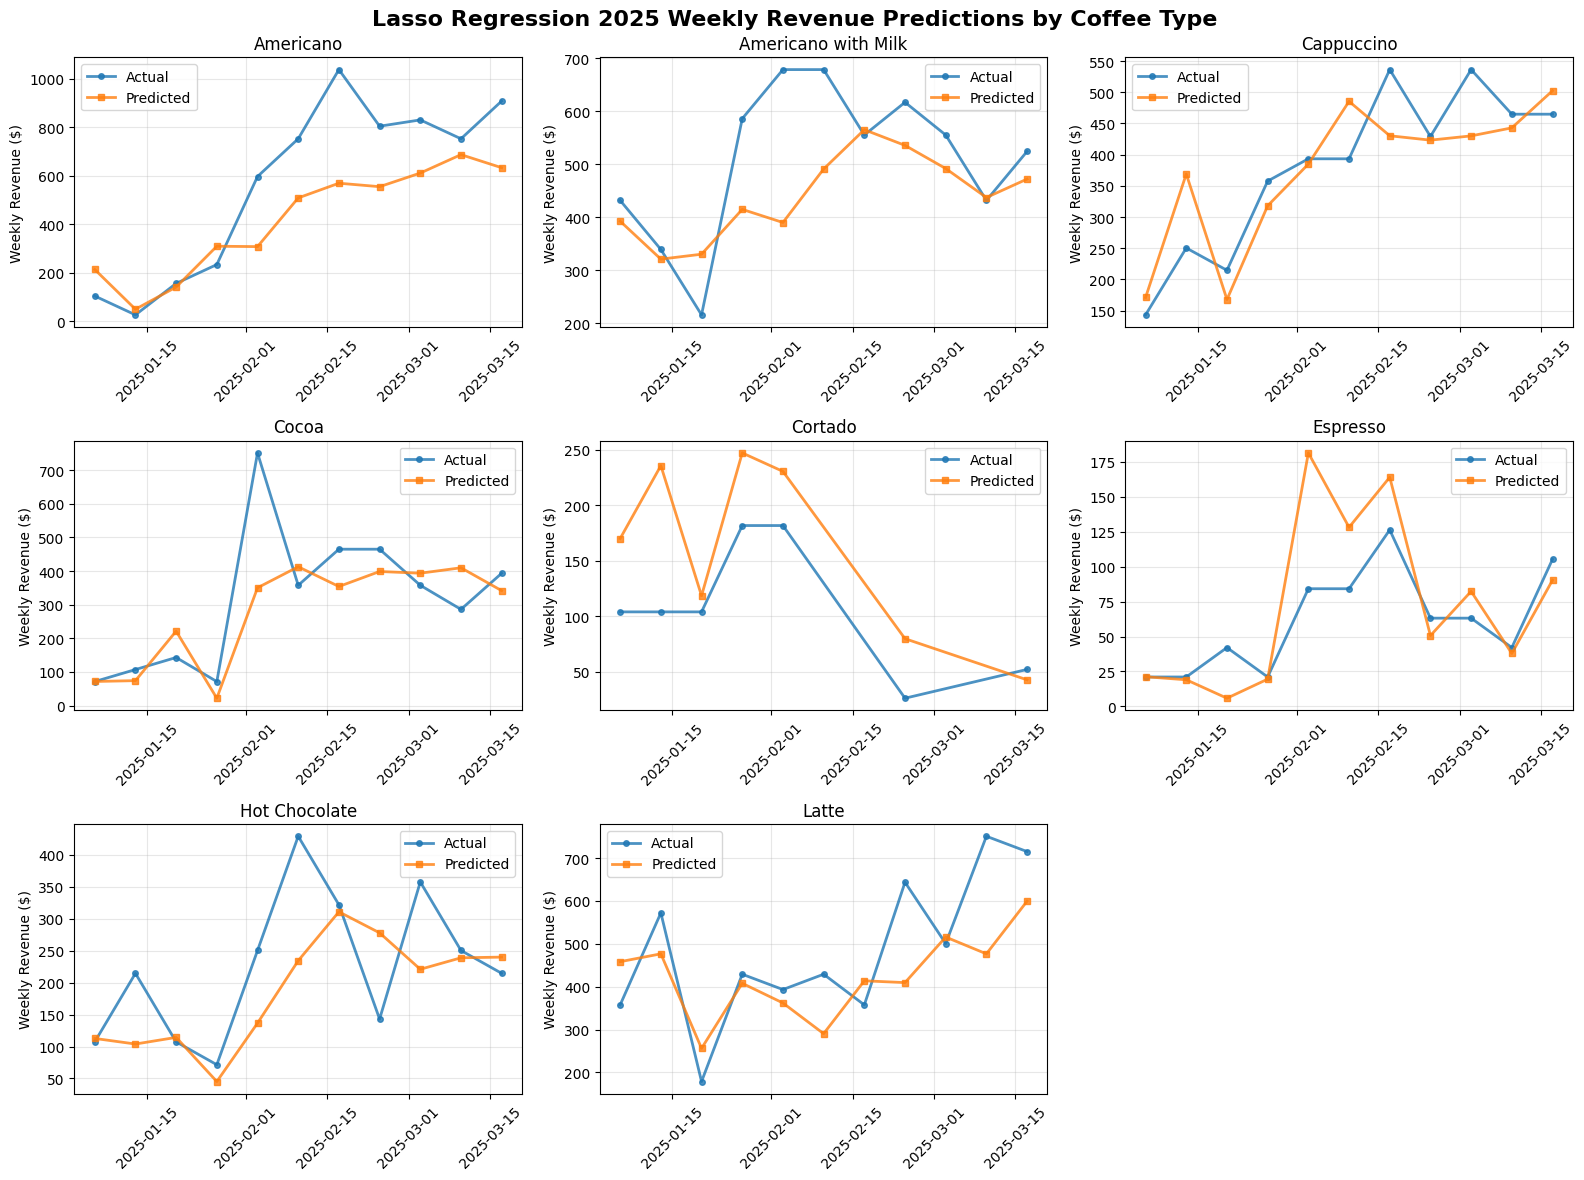

In [26]:
plot_time_series_predictions(results_lasso_2025, "Lasso Regression")

In [27]:
# Calculate average R² per coffee type for fair comparison
lasso_r2_by_coffee = results_lasso_2025.groupby('coffee_name').apply(
    lambda x: r2_score(x['actual_revenue'], x['predicted_revenue'])
)
lasso_avg_r2 = lasso_r2_by_coffee.mean()

print(f"LightGBM vs Lasso Regression (2025 predictions)")
print(f"")
print(f"Overall Performance:")
print(f"  LightGBM R²: {r2_2025:.3f} | Lasso R²: {r2_lasso_2025:.3f}")
print(f"  LightGBM MAPE: {mape_2025:.1f}% | Lasso MAPE: {mape_lasso_2025:.1f}%")
print(f"")
print(f"Average R² per Coffee Type:")
print(f"  LightGBM: {comparison['combined_r2'].mean():.3f}")
print(f"  Lasso: {lasso_avg_r2:.3f}")
print(f"")
print(f"Average MAPE per Coffee Type:")
print(f"  LightGBM: {coffee_performance_2025['mape_mean'].mean():.1f}%")
print(f"  Lasso: {coffee_performance_lasso_2025['mape_mean'].mean():.1f}%")

LightGBM vs Lasso Regression (2025 predictions)

Overall Performance:
  LightGBM R²: 0.154 | Lasso R²: 0.735
  LightGBM MAPE: 92.5% | Lasso MAPE: 31.2%

Average R² per Coffee Type:
  LightGBM: -2.011
  Lasso: 0.225

Average MAPE per Coffee Type:
  LightGBM: 59.3%
  Lasso: 5.3%


In [28]:
# Feature importance for Lasso (non-zero coefficients)
lasso_coefficients = pd.DataFrame({
    'feature': selected_features,
    'coefficient': lasso_final.coef_,
    'abs_coefficient': np.abs(lasso_final.coef_)
})

# features that weren't zeroed out by Lasso
non_zero_features = lasso_coefficients[lasso_coefficients['abs_coefficient'] > 0].sort_values('abs_coefficient', ascending=False)

print(f"Features selected by Lasso: {len(non_zero_features)} out of {len(selected_features)}")
print(f"\nTop 15 most important features (by absolute coefficient):")
print(non_zero_features.head(15)[['feature', 'coefficient']])

Features selected by Lasso: 11 out of 25

Top 15 most important features (by absolute coefficient):
                     feature  coefficient
11           hour_of_day_max   146.490049
10           hour_of_day_min  -118.273937
9            hour_of_day_std  -116.645544
1          prev_week_revenue    33.925407
3         prev_2week_revenue    23.576660
12           revenue_4w_mean    21.112373
15           revenue_8w_mean    11.401099
8                  month_cos    -9.838616
0             coffee_encoded     2.401152
13            revenue_4w_std     1.056162
24  coffee_month_interaction    -0.416788


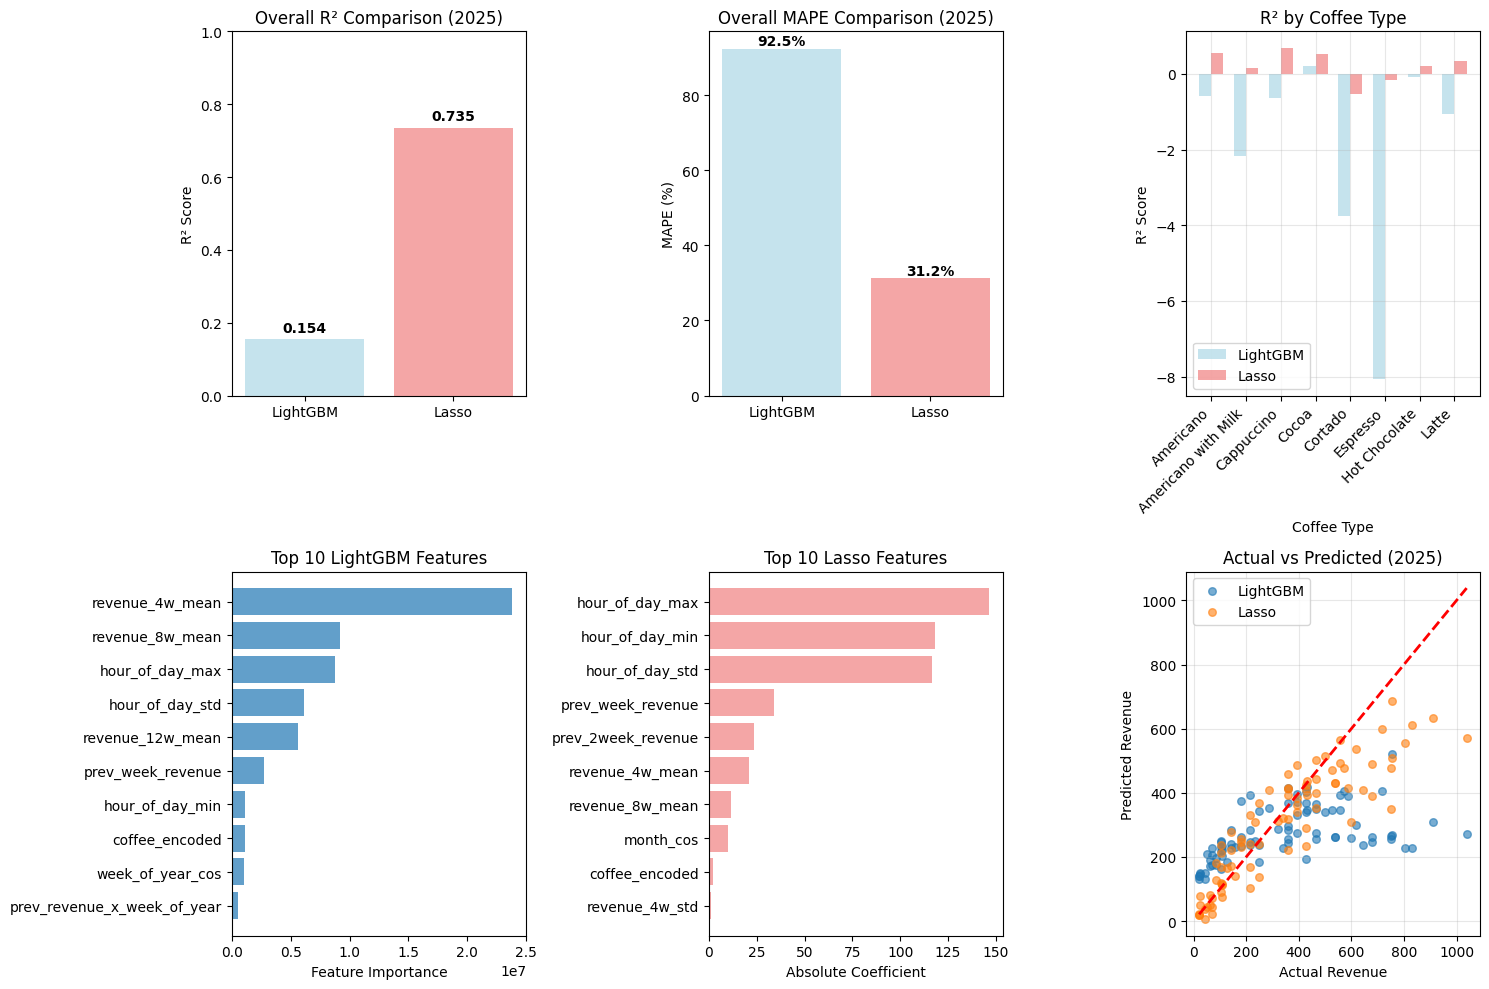

In [29]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
models = ['LightGBM', 'Lasso']
r2_scores = [r2_2025, r2_lasso_2025]
colors = ['lightblue', 'lightcoral']
bars = plt.bar(models, r2_scores, color=colors, alpha=0.7)
plt.ylabel('R² Score')
plt.title('Overall R² Comparison (2025)')
plt.ylim(0, 1)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.subplot(2, 3, 2)
mape_scores = [mape_2025, mape_lasso_2025]
bars = plt.bar(models, mape_scores, color=colors, alpha=0.7)
plt.ylabel('MAPE (%)')
plt.title('Overall MAPE Comparison (2025)')
for i, v in enumerate(mape_scores):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.subplot(2, 3, 3)
lgb_r2_by_coffee = results_2025.groupby('coffee_name').apply(
    lambda x: r2_score(x['actual_revenue'], x['predicted_revenue'])
)

coffee_names = lgb_r2_by_coffee.index
x_pos = np.arange(len(coffee_names))
width = 0.35

plt.bar(x_pos - width/2, lgb_r2_by_coffee.values, width, label='LightGBM', color='lightblue', alpha=0.7)
plt.bar(x_pos + width/2, lasso_r2_by_coffee.values, width, label='Lasso', color='lightcoral', alpha=0.7)

plt.xlabel('Coffee Type')
plt.ylabel('R² Score')
plt.title('R² by Coffee Type')
plt.xticks(x_pos, coffee_names, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
top_lgb_features = feature_importance.head(10)
top_lasso_features = non_zero_features.head(10)

plt.barh(range(len(top_lgb_features)), top_lgb_features['importance'], alpha=0.7, label='LightGBM')
plt.yticks(range(len(top_lgb_features)), top_lgb_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 LightGBM Features')
plt.gca().invert_yaxis()

plt.subplot(2, 3, 5)
plt.barh(range(len(top_lasso_features)), top_lasso_features['abs_coefficient'], alpha=0.7, color='lightcoral')
plt.yticks(range(len(top_lasso_features)), top_lasso_features['feature'])
plt.xlabel('Absolute Coefficient')
plt.title('Top 10 Lasso Features')
plt.gca().invert_yaxis()

plt.subplot(2, 3, 6)
plt.scatter(y_test_lasso, predictions_2025, alpha=0.6, label='LightGBM', s=30)
plt.scatter(y_test_lasso, predictions_lasso_2025, alpha=0.6, label='Lasso', s=30)
plt.plot([y_test_lasso.min(), y_test_lasso.max()], [y_test_lasso.min(), y_test_lasso.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted (2025)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparison Summary
* Lasso performs better overall (R²: 0.735 vs 0.517)
* Lasso has a better overall MAPE (31.2% vs. 39.3%)
* Lasso selected 11 features out of 25
* LightGBM uses complex tree interactions, Lasso uses linear relationships